# Mapa da eleição de Dep. Estadual de 2018 por Zona Eleitoral nos distritos de SP

In [ ]:
'''
Fontes:
TSE - zonas eleitorais SP e resultado eleição
- votacao_candidato_munzona_2018_SP.csv:
http://agencia.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip
- lista_zonas_eleitorais.csv:
http://www.tse.jus.br/eleitor/cartorios-e-zonas-eleitorais/pesquisa-a-zonas-eleitorais

Estadão Dados - shapefile
- zonaseleitorais2.shp:
https://groups.google.com/forum/#!topic/thackday/oJ-DRcsJL3w
'''

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
cols = ['CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'DS_CARGO',
        'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO', 
        'QT_VOTOS_NOMINAIS']

df_chunk = pd.read_csv('./votos/votacao_candidato_munzona_2018_SP.csv', sep=';', usecols=cols, encoding='latin1', chunksize=10000)

In [3]:
DS_CARGO = 'Deputado Estadual'

In [4]:
chunk_list = []

for chunk in df_chunk:  
    chunk_filter = chunk[chunk['DS_CARGO'] == DS_CARGO]
    chunk_list.append(chunk_filter)    
df_concat = pd.concat(chunk_list)

In [5]:
# Agrupar por zona e candidato
df_zona = df_concat.groupby(['NR_ZONA', 'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'NR_PARTIDO', 'SG_PARTIDO'])['QT_VOTOS_NOMINAIS'].sum().reset_index()
df_zona.set_index('NR_ZONA', drop=False, inplace=True)
df_zona.head()

,NR_ZONA,NR_CANDIDATO,NM_URNA_CANDIDATO,NR_PARTIDO,SG_PARTIDO,QT_VOTOS_NOMINAIS
NR_ZONA,,,,,,
1,1,10000,JORGE WILSON XERIFE CONSUMIDOR,10,PRB,730
1,1,10005,ROZANA FIDELES,10,PRB,0
1,1,10012,NANCY,10,PRB,4
1,1,10100,AILDO RODRIGUES,10,PRB,91
1,1,10101,HELIO GODOY,10,PRB,2


In [6]:
# Obter lista de zonas eleitorais do estado de São Paulo
df = pd.read_csv('./votos/lista_zonas_eleitorais.csv', sep=',', encoding='latin1')

In [7]:
# Filtrar somente pela cidade de São Paulo
df_sp = df[df['nome_municipio'] == 'SÃO PAULO']
df_sp.set_index('numero_zona', drop=False, inplace=True)
df_sp.shape

(58, 7)

In [8]:
df_zona_sp = df_zona.join(df_sp)
df_zona_sp.dropna(inplace=True)

In [9]:
# Definir candidato para analisar
NR_CANDIDATO = 17317

In [10]:
df_zona_sp_cand = df_zona_sp[df_zona_sp['NR_CANDIDATO'] == NR_CANDIDATO]
df_zona_sp_cand.shape
df_zona_sp_cand.head()

,NR_ZONA,NR_CANDIDATO,NM_URNA_CANDIDATO,NR_PARTIDO,SG_PARTIDO,QT_VOTOS_NOMINAIS,numero_zona,sigla_uf,endereco,cep,bairro,nome_municipio,sigla_uf.1
1,1,17317,JANAINA PASCHOAL,17,PSL,12117,1.0,26-0001,"AVENIDA BRIGADEIRO LUÍS ANTONIO, 453",1317000.0,BELA VISTA,SÃO PAULO,SP
2,2,17317,JANAINA PASCHOAL,17,PSL,18932,2.0,26-0002,"RUA DR. COSTA JÚNIOR, 509",5002000.0,AGUA BRANCA,SÃO PAULO,SP
3,3,17317,JANAINA PASCHOAL,17,PSL,4970,3.0,26-0003,"RUA ANTONIO CORUJA, 99/109",1126030.0,BOM RETIRO,SÃO PAULO,SP
4,4,17317,JANAINA PASCHOAL,17,PSL,20264,4.0,26-0004,"RUA MADRE DE DEUS, 427",3119000.0,MOOCA,SÃO PAULO,SP
5,5,17317,JANAINA PASCHOAL,17,PSL,16191,5.0,26-0005,"RUA CLODOMIRO AMAZONAS, 41",4537010.0,ITAIM BIBI,SÃO PAULO,SP


In [11]:
# Obter shapefile da cidade por zonas eleitorais
df_mapa = gpd.read_file('./geo/Zonas_eleitorais_SP_shp/zonaseleitorais2.shp')
df_mapa['Name'] = df_mapa['Name'].astype(int)
df_mapa.sort_values(by='Name', ascending=True, inplace=True)
df_mapa.set_index('Name', drop=False, inplace=True)

In [12]:
df_mapa_cand = df_mapa.join(df_zona_sp_cand)
df_mapa_cand.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

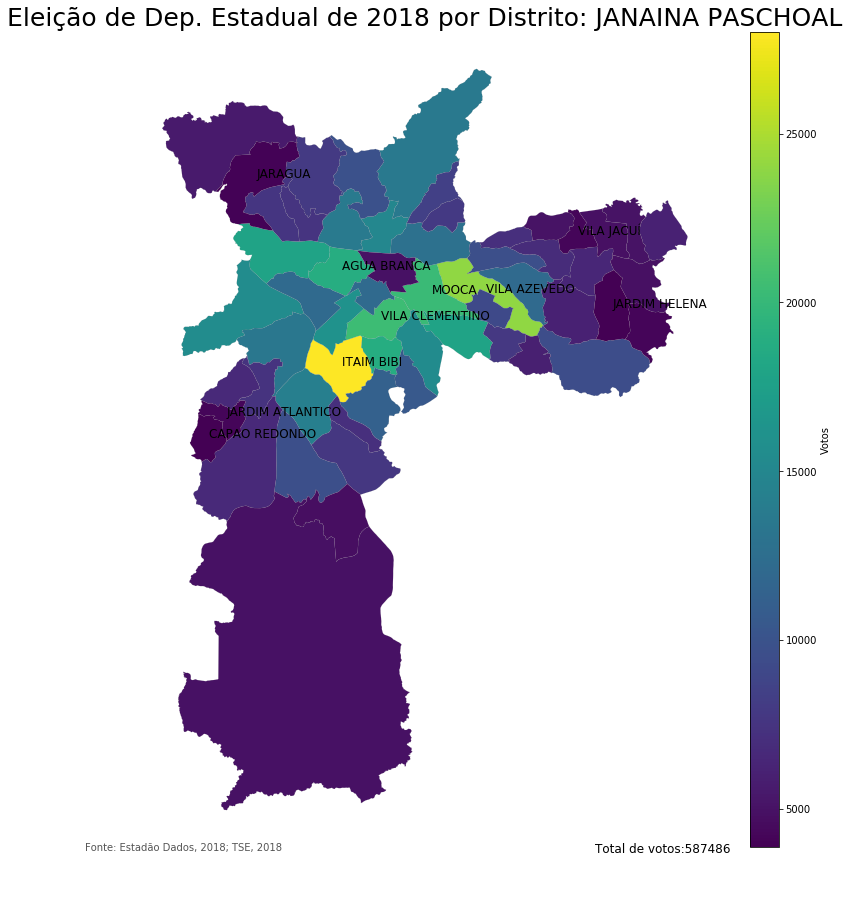

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(15,15))

df_mapa_cand["center"] = df_mapa_cand["geometry"].centroid
df_points = df_mapa_cand.copy()
df_points.set_geometry("center", inplace = True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

ax = df_mapa_cand.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': 'Votos', 'orientation': 'vertical'}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')

for x, y, label in zip(df_points[:5].geometry.x, df_points[:5].geometry.y, df_points[:5]['bairro']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)
    
for x, y, label in zip(df_points[-5:].geometry.x, df_points[-5:].geometry.y, df_points[-5:]['bairro']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)
    
ax.set_axis_off()
ax.set_title('Eleição de Dep. Estadual de 2018 por Distrito: ' + df_mapa_cand['NM_URNA_CANDIDATO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})

ax.annotate('Total de votos:' + str(df_mapa_cand['QT_VOTOS_NOMINAIS'].sum()), xy=(0.7,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)

ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

plt.show()
fig.savefig('sp-distrito-'+ str(df_mapa_cand['NR_CANDIDATO'].iloc[0]) +'.png')

In [14]:
ranking = df_mapa_cand[['bairro','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'Name':'Zona'}, inplace = True)

In [15]:
ranking.head()

,Zona,bairro,QT_VOTOS_NOMINAIS,%
0,258,ITAIM BIBI,28020,4.769475
1,253,VILA AZEVEDO,24010,4.086906
2,6,VILA CLEMENTINO,20442,3.479572
3,4,MOOCA,20264,3.449274
4,2,AGUA BRANCA,18932,3.222545


In [16]:
ranking.tail()

,Zona,bairro,QT_VOTOS_NOMINAIS,%
53,373,JARDIM ATLANTICO,4171,0.709974
54,398,VILA JACUÍ,4149,0.706230
55,403,JARAGUA,4022,0.684612
56,405,JARDIM HELENA,3947,0.671846
57,20,CAPAO REDONDO,3861,0.657207


In [17]:
# Definir partido para analisar
NR_PARTIDO = 13

In [18]:
df_zona_sp_part = df_zona_sp[df_zona_sp['NR_PARTIDO'] == NR_PARTIDO]
df_zona_sp_part = df_zona_sp_part.groupby(['NR_ZONA','SG_PARTIDO', 'bairro'])['QT_VOTOS_NOMINAIS'].sum().reset_index()
df_zona_sp_part.set_index('NR_ZONA', drop=False, inplace=True)

In [19]:
df_mapa_part = df_mapa.join(df_zona_sp_part)
df_mapa_part.sort_values('QT_VOTOS_NOMINAIS', ascending=False, inplace=True)

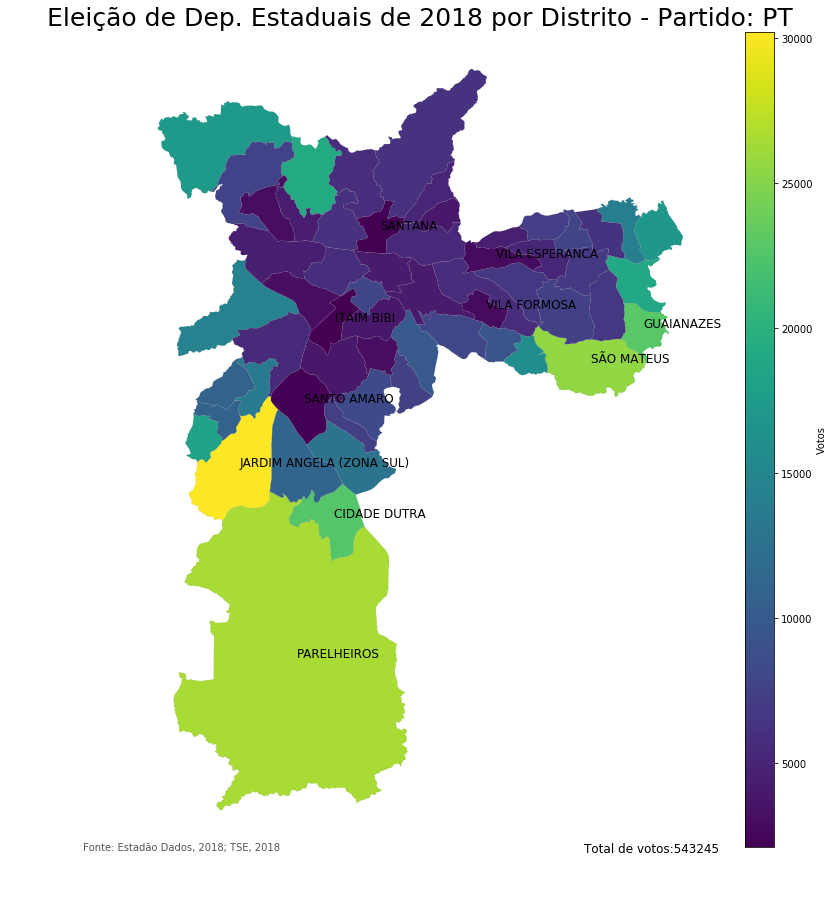

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(15,15))

df_mapa_part["center"] = df_mapa_part["geometry"].centroid
df_points = df_mapa_part.copy()
df_points.set_geometry("center", inplace = True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)

ax = df_mapa_part.plot(column='QT_VOTOS_NOMINAIS', legend=True,
                       legend_kwds={'label': 'Votos', 'orientation': 'vertical'}, 
                       linewidth=0.1, ax=ax, cax=cax, edgecolor='grey')

for x, y, label in zip(df_points[:5].geometry.x, df_points[:5].geometry.y, df_points[:5]['bairro']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)
    
for x, y, label in zip(df_points[-5:].geometry.x, df_points[-5:].geometry.y, df_points[-5:]['bairro']):
    ax.annotate(label, xy=(x, y), xytext=(1,1), textcoords="offset points", fontsize=12)

ax.set_axis_off()
ax.set_title('Eleição de Dep. Estaduais de 2018 por Distrito - Partido: ' + df_mapa_part['SG_PARTIDO'].iloc[0], fontdict={'fontsize':'25', 'fontweight':'3'})
ax.annotate('Total de votos:' + str(df_mapa_part['QT_VOTOS_NOMINAIS'].sum()), xy=(0.7,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12)
ax.annotate('Fonte: Estadão Dados, 2018; TSE, 2018', xy=(0.1,0.08),
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

plt.show()
fig.savefig('sp-distrito-partido-'+df_mapa_part['SG_PARTIDO'].iloc[0]+'.png')

In [21]:
ranking = df_mapa_part[['bairro','QT_VOTOS_NOMINAIS']].sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index()
ranking['%'] = ranking['QT_VOTOS_NOMINAIS'] / ranking['QT_VOTOS_NOMINAIS'].sum() * 100
ranking.rename(columns = {'Name':'Zona'}, inplace = True)

In [22]:
ranking.head()

,Zona,bairro,QT_VOTOS_NOMINAIS,%
0,372,JARDIM ANGELA (ZONA SUL),30220,5.562868
1,381,PARELHEIROS,26563,4.889691
2,375,SÃO MATEUS,25544,4.702114
3,404,GUAIANAZES,22870,4.209887
4,371,CIDADE DUTRA,22690,4.176753


In [23]:
ranking.tail()

,Zona,bairro,QT_VOTOS_NOMINAIS,%
53,252,VILA ESPERANCA,2967,0.546162
54,348,VILA FORMOSA,2918,0.537143
55,246,SANTO AMARO,2263,0.416571
56,5,ITAIM BIBI,2206,0.406078
57,249,SANTANA,2104,0.387302
